## Load Data + Pre-Process

### Imports and basic functions

In [43]:
from pathlib import Path
import json
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import skimage
import cv2
import seaborn as sns
import datetime
from sklearn.decomposition import NMF
import napari
import zarr
import dask.array as da
from tifffile import imread, imwrite
import imagecodecs
from matplotlib.backends.backend_qt5agg import FigureCanvas
from matplotlib import cm
import matplotlib

In [2]:
date = str(datetime.date.today())
print(date)

2022-09-23


In [4]:
def gen_ion_image(intensity_vector, yx_coords):

    y_extent = int(np.max(yx_coords[:, 0])) + 1
    x_extent = int(np.max(yx_coords[:, 1])) + 1

    pix_map_arr = np.zeros((y_extent, x_extent), dtype=np.float32)

    pix_map_arr[yx_coords[:, 0], yx_coords[:, 1]] = intensity_vector
    return pix_map_arr

In [5]:
def mpl_contour_to_geojson(vertices, level_value, ims_translation, scale_factor, name="m/z whatever"):
    geo_type = "LineString"

    properties = {
        "object_type": "detection",
        "classification": {"name": "m/z contour", "colorRGB": -3140401},
        "isLocked": False,
        "measurements": [{"name": name, "value": level_value}],
    }
    vertices = vertices[:, [1, 0]]
    vertices[:,0] += ims_translation[0]
    vertices[:,1] += ims_translation[1]
    micro_vertices = vertices * scale_factor

    geojson_dict = {
        "type": "Feature",
        "geometry": {
            "type": geo_type,
            "coordinates": micro_vertices.tolist(),
        },
        "properties": properties,
    }

    return geojson_dict

In [6]:
def tifffile_to_dask(im_fp):
    imdata = zarr.open(imread(im_fp, aszarr=True))
    if isinstance(imdata, zarr.hierarchy.Group):
        imdata = [da.from_zarr(imdata[z]) for z in imdata.array_keys()]
    else:
        imdata = da.from_zarr(imdata)
    return imdata

### Load IMS data

In [7]:
# data files
ims_folder = "C:/Users/sharmak1/Desktop/210729_AutomatedMaskGeneration/data/Aligned_Annotated_IMS/MuKid_sec093-IMS"
intersection_h5_fp = "C:/Users/sharmak1/Desktop/210729_AutomatedMaskGeneration/data/Aligned_Annotated_IMS/MuKid_sec093_coords-annos-interesected.h5"

# read ims data and peak metadata
ims_data_h5_fp = (Path(ims_folder) / "peaks_ppm=3_c9bd1b4a80861d707bcad007729a42b4.h5")

### Normalize IMS data

In [8]:
ims_normalizations_fp = Path(ims_folder) / "global-normalizations.npz"
ims_data_h5 = h5py.File(ims_data_h5_fp)
# peak picked m/z values
mz_vals = np.array(ims_data_h5["Annotations"]["Centroids"]["annotations"])

ims_intensity_data = ims_data_h5["Array"]["array"]

In [9]:
# normalize all intensity data using 5-95% normalization
normalizations = np.load(ims_normalizations_fp)
norm_5_95 = np.where(normalizations["names"] == "5-95%")[0]

norm_vec = normalizations["normalizations"][:, norm_5_95]
norm_vec.shape

ims_intensity_data_norm = np.divide(ims_intensity_data, norm_vec)
ims_intensity_data_norm.shape

(370253, 394)

In [10]:
ims_intensity_data_norm

array([[   0.      ,    0.      ,    0.      , ...,    0.      ,
           0.      ,    0.      ],
       [   0.      ,    0.      ,    0.      , ...,    0.      ,
         780.1347  ,    0.      ],
       [   0.      ,    0.      ,   82.70493 , ...,    0.      ,
        1045.336   ,    0.      ],
       ...,
       [   0.      ,    0.      ,  160.48473 , ...,    0.      ,
           0.      ,    0.      ],
       [   0.      ,    0.      ,    0.      , ...,  303.9776  ,
           0.      ,    0.      ],
       [  16.096983,   73.48623 ,  168.66838 , ...,    0.      ,
           0.      ,    0.      ]], dtype=float32)

In [11]:
#save normalized intensity data
hf = h5py.File('C:/Users/sharmak1/Desktop/210729_AutomatedMaskGeneration/data/Aligned_Annotated_IMS/outs/' + date + '_normalizedIntensityData.h5', 'w')
hf.create_dataset('5-95%', data=ims_intensity_data_norm)
hf.close()

In [12]:
#load normalized intensity data
ims_intensity_data_norm = h5py.File('C:/Users/sharmak1/Desktop/210729_AutomatedMaskGeneration/data/Aligned_Annotated_IMS/outs/' + date + '_normalizedIntensityData.h5')
ims_intensity_data_norm = ims_intensity_data_norm['5-95%']
ims_intensity_data_norm.shape

(370253, 394)

### Import and pre-process intersection data (pathology annotations)

In [13]:
# import and clean up intersection data (contains extra rois)
intersection_data = pd.read_csv("C:/Users/sharmak1/Desktop/210729_AutomatedMaskGeneration/data/Aligned_Annotated_IMS/MuKid_sec093_coords-annos-interesected.csv.gz")

roi_names, roi_len = np.unique(
    intersection_data["regions"], return_counts=True
)
exclude_abl_fid_roi = roi_names[np.argmax(roi_len)]
intersection_data = intersection_data[
    intersection_data["regions"] == exclude_abl_fid_roi
]
# get yx coords for plotting images
intersection_data['y_minimized'] = intersection_data['y_minimized'] - np.min(intersection_data['y_minimized'])
intersection_data['x_minimized'] = intersection_data['x_minimized'] - np.min(intersection_data['x_minimized'])

x_translate = np.min(intersection_data["x_padded"])
y_translate = np.min(intersection_data["y_padded"])


In [14]:
intersection_data

regions  x_original  y_original  x_minimized  y_minimized  x_padded  \
0             0        4433         339          303            0       333   
1             0        4434         339          304            0       334   
2             0        4435         339          305            0       335   
3             0        4436         339          306            0       336   
4             0        4437         339          307            0       337   
...         ...         ...         ...          ...          ...       ...   
370248        0        4404        1308          274          969       304   
370249        0        4405        1308          275          969       305   
370250        0        4406        1308          276          969       306   
370251        0        4407        1308          277          969       307   
370252        0        4408        1308          278          969       308   

        y_padded  Adrenal Gland-000  Bacterial Colony-000  \
0             10                0.0                   0.0   
1             10                0.0                   0.0   
2             10                0.0                   0.0   
3             10                0.0                   0.0   
4             10                0.0                   0.0   
...          ...                ...                   ...   
370248       979                0.0                   0.0   
370249       979                0.0                   0.0   
370250       979                0.0                   0.0   
370251       979                0.0                   0.0   
370252       979                0.0                   0.0   

        Bacterial Colony-001  ...  Inflammatory cell infiltrate-026  \
0                        0.0  ...                               0.0   
1                        0.0  ...                               0.0   
2                        0.0  ...                               0.0   
3                        0.0  ...                               0.0   
4                        0.0  ...                               0.0   
...                      ...  ...                               ...   
370248                   0.0  ...                               0.0   
370249                   0.0  ...                               0.0   
370250                   0.0  ...                               0.0   
370251                   0.0  ...                               0.0   
370252                   0.0  ...                               0.0   

        Inflammatory cell infiltrate-027  Inflammatory cell infiltrate-028  \
0                                    0.0                               0.0   
1                                    0.0                               0.0   
2                                    0.0                               0.0   
3                                    0.0                               0.0   
4                                    0.0                               0.0   
...                                  ...                               ...   
370248                               0.0                               0.0   
370249                               0.0                               0.0   
370250                               0.0                               0.0   
370251                               0.0                               0.0   
370252                               0.0                               0.0   

        Inflammatory cell infiltrate-029  Inflammatory cell infiltrate-030  \
0                                    0.0                               0.0   
1                                    0.0                               0.0   
2                                    0.0                               0.0   
3                                    0.0                               0.0   
4                                    0.0                               0.0   
...                                  ...                            

In [15]:
tissue_rois = [
    'Bacterial Colony',
    'Freeze artifact',
    'Inflammatory cell infiltrate',
    'Major Abcess',
    'Renal cortex',
    'Renal medulla',
    'Renal pelvis',
    'Tissue fold/debris overlying tissue',
]

In [16]:
#add column per tissue ROI to label all px belonging to that ROI
for troi in tissue_rois:
    all_mask = intersection_data.filter(regex=troi)
    all_mask = all_mask.sum(axis=1)
    intersection_data[f"{troi}-All"] = all_mask
    
intersection_data

regions  x_original  y_original  x_minimized  y_minimized  x_padded  \
0             0        4433         339          303            0       333   
1             0        4434         339          304            0       334   
2             0        4435         339          305            0       335   
3             0        4436         339          306            0       336   
4             0        4437         339          307            0       337   
...         ...         ...         ...          ...          ...       ...   
370248        0        4404        1308          274          969       304   
370249        0        4405        1308          275          969       305   
370250        0        4406        1308          276          969       306   
370251        0        4407        1308          277          969       307   
370252        0        4408        1308          278          969       308   

        y_padded  Adrenal Gland-000  Bacterial Colony-000  \
0             10                0.0                   0.0   
1             10                0.0                   0.0   
2             10                0.0                   0.0   
3             10                0.0                   0.0   
4             10                0.0                   0.0   
...          ...                ...                   ...   
370248       979                0.0                   0.0   
370249       979                0.0                   0.0   
370250       979                0.0                   0.0   
370251       979                0.0                   0.0   
370252       979                0.0                   0.0   

        Bacterial Colony-001  ...  Renal pelvis-000  \
0                        0.0  ...               0.0   
1                        0.0  ...               0.0   
2                        0.0  ...               0.0   
3                        0.0  ...               0.0   
4                        0.0  ...               0.0   
...                      ...  ...               ...   
370248                   0.0  ...               0.0   
370249                   0.0  ...               0.0   
370250                   0.0  ...               0.0   
370251                   0.0  ...               0.0   
370252                   0.0  ...               0.0   

        Tissue fold/debris overlying tissue-000  Bacterial Colony-All  \
0                                           0.0                   0.0   
1                                           0.0                   0.0   
2                                           0.0                   0.0   
3                                           0.0                   0.0   
4                                           0.0                   0.0   
...                                         ...                   ...   
370248                                      0.0                   0.0   
370249                                      0.0                   0.0   
370250                                      0.0                   0.0   
370251                                      0.0                   0.0   
370252                                      0.0                   0.0   

        Freeze artifact-All  Inflammatory cell infiltrate-All  \
0                       0.0                               0.0   
1                       0.0                               0.0   
2                       0.0                               0.0   
3                       0.0                               0.0   
4                       0.0                               0.0   
...                     ...                               ...   
370248                  0.0                               0.0   
370249                  0.0                               0.0   
370250                  0.0                               0.0   
370251                  0.0                               0.0   
370252                  0.0                               0.0   

       

### Load in m/z annotations

In [17]:
mzAnnotations = pd.read_csv("C:/Users/sharmak1/Desktop/210729_AutomatedMaskGeneration/data/Aligned_Annotated_IMS/annotations_fdr=0.25.csv")
mzAnnotations

Unnamed: 0       formula adduct       formula.1    formula+adduct  \
0             1    C15H22NO6P     +H      C15H23NO6P     C15H22NO6P+H+   
1             1      C21H14O7     +H        C21H15O7       C21H14O7+H+   
2             1    C24H50NO7P     +K     C24H50NO7PK     C24H50NO7P+K+   
3             1    C24H50NO7P    +Na    C24H50NO7PNa    C24H50NO7P+Na+   
4             1     C25H26O12     +H       C25H27O12      C25H26O12+H+   
..          ...           ...    ...             ...               ...   
435           1  C87H168O17P2     +H    C87H169O17P2   C87H168O17P2+H+   
436           1  C87H168O17P2    +Na  C87H168O17P2Na  C87H168O17P2+Na+   
437           1  C89H158O17P2     +H    C89H159O17P2   C89H158O17P2+H+   
438           1  C89H166O17P2     +H    C89H167O17P2   C89H166O17P2+H+   
439           1  C89H166O17P2    +Na  C89H166O17P2Na  C89H166O17P2+Na+   

              mz    ms_msm  ms_spatial  ms_spectral  ms_chaos  fdr  \
0     344.125672  0.056370    0.059077     0.962252  0.991605  0.2   
1     379.081151  0.061884    0.066058     0.943645  0.992754  0.2   
2     534.295569  0.182326    0.191034     0.955972  0.998368  0.2   
3     518.321632  0.145608    0.153326     0.951270  0.998309  0.2   
4     519.149624  0.064562    0.069557     0.933682  0.994125  0.2   
..           ...       ...         ...          ...       ...  ...   
435  1548.182875  0.064954    0.090638     0.720785  0.994235  0.2   
436  1570.164819  0.138219    0.197307     0.704378  0.994531  0.2   
437  1562.104625  0.093087    0.123338     0.762714  0.989532  0.2   
438  1570.167225  0.224728    0.301433     0.749632  0.994531  0.1   
439  1592.149169  0.202176    0.279418     0.726496  0.995961  0.2   

                                            annotation  \
0    ['phenyl [1-(N-succinylamino)pentyl]phosphonate']   
1     ['Anastatin A', 'Anastatin B', 'Tephcalostan C']   
2    ['PC(0:0/16:0)', 'PC(16:0/0:0)[rac]', 'PC(O-14...   
3    ['PC(0:0/16:0)', 'PC(16:0/0:0)[rac]', 'PC(O-14...   
4    ["Scutellarein 6,4'-dimethyl ether 7-(6''-acet...   
..                                                 ...   
435  ["CL(1'-[20:0/18:1(9Z)],3'-[20:0/20:0])", "CL(...   
436  ["CL(1'-[20:0/18:1(9Z)],3'-[20:0/20:0])", "CL(...   
437  ["CL(1'-[20:0/20:4(5Z,8Z,11Z,14Z)],3'-[20:4(5Z...   
438  ["CL(1'-[20:0/20:0],3'-[20:0/20:4(5Z,8Z,11Z,14...   
439  ["CL(1'-[20:0/20:0],3'-[20:0/20:4(5Z,8Z,11Z,14...   

                                        annotation_ids  
0                                     ['LMFA08020199']  
1     ['LMPK12140273', 'LMPK12140274', 'LMPK12090004']  
2    ['LMGP01050074', 'LMGP01050113', 'LMGP01020019...  
3    ['LMGP01050074', 'LMGP01050113', 'LMGP01020019...  
4                     ['LMPK12111157', 'LMPK12070006']  
..                                                 ...  
435  ['LMGP12010971', 'LMGP12011031', 'LMGP12010611...  
436  ['LMGP12010971', 'LMGP12011031', 'LMGP12010611...  
437  ['LMGP12011085', 'LMGP12011260', 'LMGP12011050...  
438  ['LMGP12011044', 'LMGP12011079', 'LMGP12011259...  
439  ['LMGP12011044', 'LMGP12011079', 'LMGP12011259...  

[440 rows x 13 columns]

### Remove adrenal gland

In [18]:
intersection_data.shape

(370253, 104)

In [19]:
intersection_data_noAG = intersection_data[intersection_data['Adrenal Gland-000']==0]
intersection_data_noAG.shape

(354022, 104)

In [20]:
ims_intensity_data_norm.shape

(370253, 394)

In [21]:
noAG_idx = np.where(intersection_data['Adrenal Gland-000']==0)[0]
ims_intensity_data_norm = ims_intensity_data_norm[noAG_idx,:]
ims_intensity_data_norm.shape

(354022, 394)

### Get coordinates for visualization

In [22]:
# get yx coords for plotting images
yx_coords = np.asarray(intersection_data_noAG[['y_minimized', 'x_minimized']])
yx_coords.shape


(354022, 2)

In [23]:
np.save("C:/Users/sharmak1/Desktop/210729_AutomatedMaskGeneration/data/Aligned_Annotated_IMS/outs/yxCoords.npy", yx_coords)

## Correlation Analysis

In [24]:
ims_intensity_data_norm_df = pd.DataFrame(ims_intensity_data_norm, columns = mz_vals)
ims_intensity_data_norm_df

496.340057  508.375671  511.200043  518.321594  520.339600  \
0         0.000000    0.000000    0.000000    0.000000    0.000000   
1         0.000000    0.000000    0.000000    0.000000    0.000000   
2         0.000000    0.000000   82.704933    0.000000    0.000000   
3         0.000000    0.000000  169.988434    0.000000    0.000000   
4         0.000000    0.000000    0.000000    0.000000    0.000000   
...            ...         ...         ...         ...         ...   
354017   39.505524    0.000000    0.000000    0.000000  123.005829   
354018    0.000000   22.747173    0.000000  319.302917    0.000000   
354019    0.000000    0.000000  160.484726  465.060577    0.000000   
354020    0.000000    0.000000    0.000000  215.136017   47.904781   
354021   16.096983   73.486229  168.668381  370.230591  123.176910   

        522.251221  522.355286  524.370911  525.374268  534.295410  ...  \
0       365.068817    0.000000    0.000000    0.000000    0.000000  ...   
1       511.073669    0.000000    0.000000    0.000000    0.000000  ...   
2       761.970032    0.000000    0.000000    0.000000    0.000000  ...   
3       458.540253    0.000000    0.000000    0.000000    0.000000  ...   
4       361.488525    0.000000    0.000000    0.000000   36.806103  ...   
...            ...         ...         ...         ...         ...  ...   
354017  115.823006  219.076080  849.368713  215.484665  281.925781  ...   
354018    0.000000  219.046844  749.814209  230.841675  228.314209  ...   
354019  166.524475   56.946190  478.002869  233.824509  267.474548  ...   
354020  133.262390  131.520401  573.986389  158.521271  252.588852  ...   
354021  167.268646  252.652649  716.665649  191.764053  179.166412  ...   

        922.405090  923.412598  924.420959  925.427917  926.436707  \
0         0.000000    0.000000    0.000000    0.000000  114.929070   
1         0.000000  173.679626  138.089539   37.013691    0.000000   
2         0.000000  206.084427    0.000000   86.772385   56.944378   
3       211.414185    0.000000    0.000000   61.424393    0.000000   
4         0.000000    0.000000    0.000000    0.000000    0.000000   
...            ...         ...         ...         ...         ...   
354017  154.430679   66.441109  117.618713  197.527618   95.172394   
354018    0.000000    0.000000  150.805328  105.310982    0.000000   
354019    0.000000    0.000000   50.906445   93.184677  107.852638   
354020  211.652039   82.744621  158.521271   93.196571   94.938568   
354021    0.000000  132.975067  138.574020  133.674942   81.184784   

        930.361328   931.368286   932.375061   933.383057  936.708801  
0         0.000000  1239.881836     0.000000     0.000000    0.000000  
1         0.000000  1124.646729     0.000000   780.134705    0.000000  
2       683.332520     0.000000     0.000000  1045.336060    0.000000  
3       762.805237     0.000000  1041.357788   997.075012    0.000000  
4         0.000000   895.177002   650.679321  1012.167847   53.894653  
...            ...          ...          ...          ...         ...  
354017  366.323944     0.000000   299.882843   298.984985    0.000000  
354018  267.911133   411.976562     0.000000     0.000000    0.000000  
354019  270.925812   253.669403     0.000000     0.000000    0.000000  
354020  270.879761     0.000000   303.977600     0.000000    0.000000  
354021  312.841370     0.000000     0.000000     0.000000    0.000000  

[354022 rows x 394 columns]

In [25]:
#pearson correlation analysis across all masks and m/z values
intersection_data_for_corr = intersection_data.drop(['regions', 'x_original', 'y_original', 'x_minimized', 'y_minimized',
       'x_padded', 'y_padded'], axis=1)
corr_result = pd.concat([ims_intensity_data_norm_df, intersection_data_for_corr], axis=1).corr()
corr_result

496.3400573730469  \
496.3400573730469                                 1.000000   
508.37567138671875                               -0.004235   
511.2000427246094                                 0.009217   
518.3215942382812                                 0.070022   
520.339599609375                                  0.105951   
...                                                    ...   
Major Abcess-All                                 -0.049117   
Renal cortex-All                                  0.035655   
Renal medulla-All                                 0.038364   
Renal pelvis-All                                 -0.015523   
Tissue fold/debris overlying tissue-All          -0.010462   

                                         508.37567138671875  \
496.3400573730469                                 -0.004235   
508.37567138671875                                 1.000000   
511.2000427246094                                 -0.099132   
518.3215942382812                                 -0.044391   
520.339599609375                                   0.178961   
...                                                     ...   
Major Abcess-All                                   0.113818   
Renal cortex-All                                   0.089638   
Renal medulla-All                                  0.107901   
Renal pelvis-All                                  -0.096830   
Tissue fold/debris overlying tissue-All           -0.016576   

                                         511.2000427246094  518.3215942382812  \
496.3400573730469                                 0.009217           0.070022   
508.37567138671875                               -0.099132          -0.044391   
511.2000427246094                                 1.000000          -0.021371   
518.3215942382812                                -0.021371           1.000000   
520.339599609375                                  0.003020           0.364437   
...                                                    ...                ...   
Major Abcess-All                                 -0.009330           0.004594   
Renal cortex-All                                 -0.151120           0.080773   
Renal medulla-All                                 0.130398           0.049834   
Renal pelvis-All                                  0.059564          -0.009296   
Tissue fold/debris overlying tissue-All          -0.011434           0.030547   

                                         520.339599609375  522.251220703125  \
496.3400573730469                                0.105951         -0.056287   
508.37567138671875                               0.178961         -0.228383   
511.2000427246094                                0.003020          0.045912   
518.3215942382812                                0.364437         -0.163627   
520.339599609375                                 1.000000         -0.286469   
...                                                   ...               ...   
Major Abcess-All                                -0.072057         -0.042818   
Renal cortex-All                                -0.032720         -0.181197   
Renal medulla-All                                0.390715         -0.113678   
Renal pelvis-All                                -0.148659          0.054050   
Tissue fold/debris overlying tissue-All         -0.023880          0.003827   

                                         522.3552856445312  524.3709106445312  \
496.3400573730469                                 0.105662           0.133361   
508.37567138671875                                0.166275          -0.069827   
511.2000427246094                                 0.017390           0.075292   
518.3215942382812                                 0.359185           0.380087   
520.339599609375                                  0.805384           0.609067   
...                                                    ...                ...   
Major Abcess-All                                 -

In [26]:
corr_result.to_csv('C:/Users/sharmak1/Desktop/210729_AutomatedMaskGeneration/data/Aligned_Annotated_IMS/outs/' + date + '_corr_result.csv')

### Bar graphs of top m/z's for each ROI

In [47]:
for troi in tissue_rois:
    troi_name = troi.replace("/", " ") 
    df = pd.DataFrame(corr_result[troi + '-All'].sort_values(ascending=False)[0:20])
    df.to_csv('C:/Users/sharmak1/Desktop/210729_AutomatedMaskGeneration/data/Aligned_Annotated_IMS/outs/' + date + '_' + troi_name + '_corrLipids.csv')


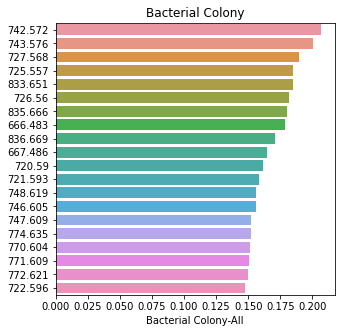

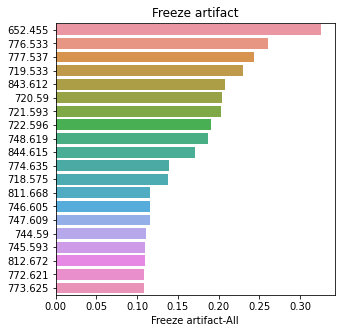

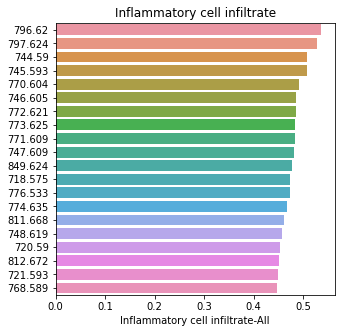

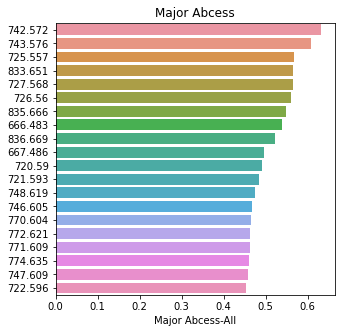

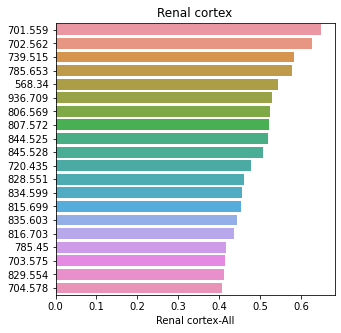

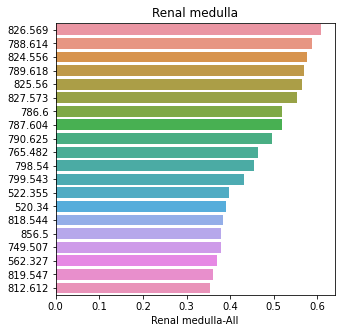

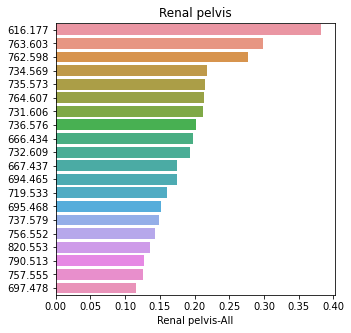

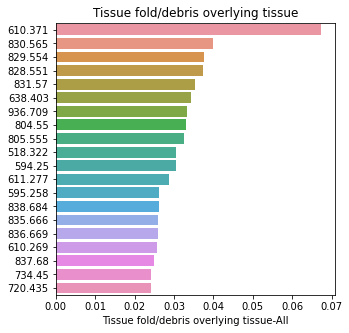

In [48]:
for troi in tissue_rois:
    troi_name = troi.replace("/", " ") 
    df = pd.DataFrame(corr_result[troi + '-All'].sort_values(ascending=False)) #sort correlation values from highest to lowest
    df = df[df.index.to_series().apply(lambda x: isinstance(x, float))] #remove non-float rows i.e. those with ROI labels
    df['temp'] = df.index.to_series().apply(lambda x: round(x,3)) #round m/z to 3 sig figs
    df = df.set_index('temp') #set index as rounded m/z vals
    df.index.name=None #remove name of index
    df.index = df.index.astype('str') #set index type as str
    df = df.iloc[0:20] # select 20 highest correlated m/z values
    plt.figure(figsize=(5,5))
    sns.barplot(y=df.index, x=troi+'-All', data=df, orient = 'h')
    plt.title(troi)
    plt.savefig('C:/Users/sharmak1/Desktop/210729_AutomatedMaskGeneration/data/Aligned_Annotated_IMS/outs/' + date + '_' + troi_name + '_corrLipids.svg', bbox_inches = "tight")

### Export ion images of top correlated mz ion per ROI

In [27]:
for troi in tissue_rois:
    troi_name = troi.replace("/", " ") 
    df = pd.DataFrame(corr_result[troi + '-All'].sort_values(ascending=False)) #sort correlation values from highest to lowest
    df = df[df.index.to_series().apply(lambda x: isinstance(x, float))] #remove non-float rows i.e. those with ROI labels
    top_mz = df.index[0]
    top_mz_idx = np.where(mz_vals==top_mz)[0]
    intensity_vector = ims_intensity_data_norm_df.iloc[:,top_mz_idx]
    intensity_vector = intensity_vector.iloc[:,0]
    top_mz_ion_image = gen_ion_image(intensity_vector, yx_coords)
    plt.figure(figsize=(15,15))
    imwrite("C:/Users/sharmak1/Desktop/210729_AutomatedMaskGeneration/data/Aligned_Annotated_IMS/outs/" + date + "_" + troi_name + "_mz" + str(top_mz) + ".tiff", top_mz_ion_image, compression="deflate")



<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

### Export contour map for top correlated mz ion per ROI

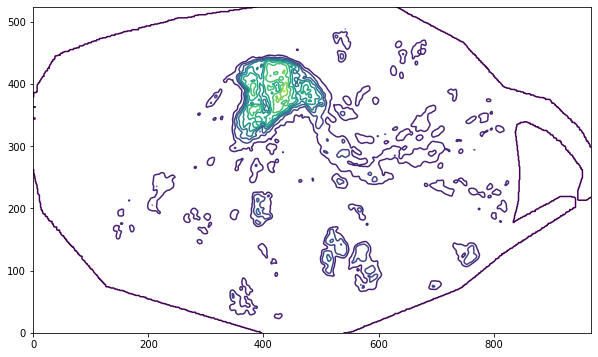

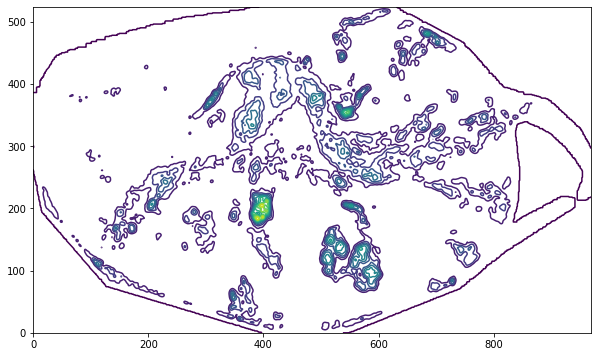

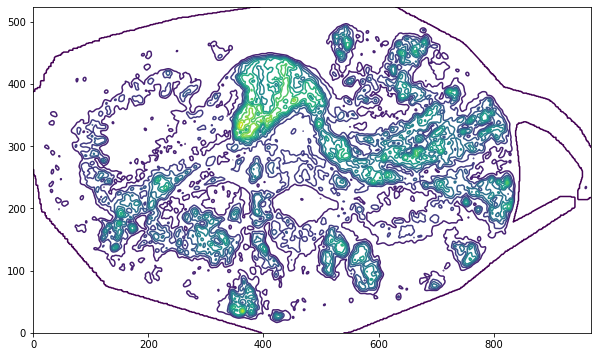

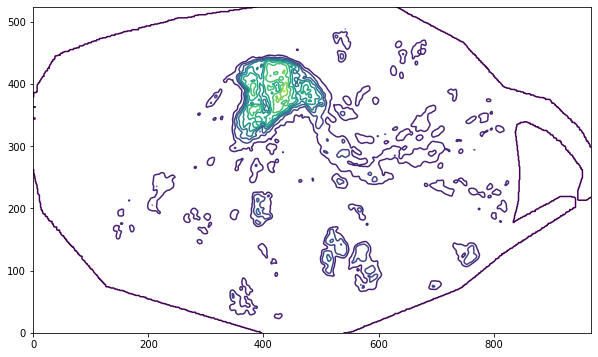

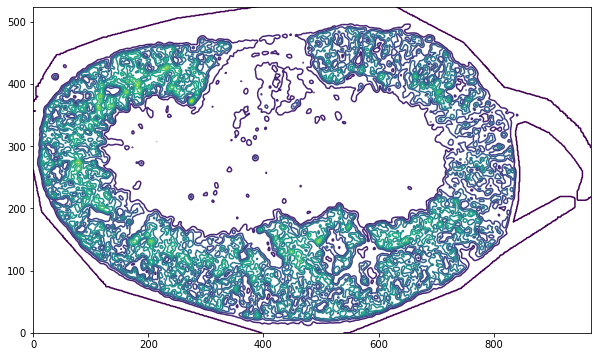

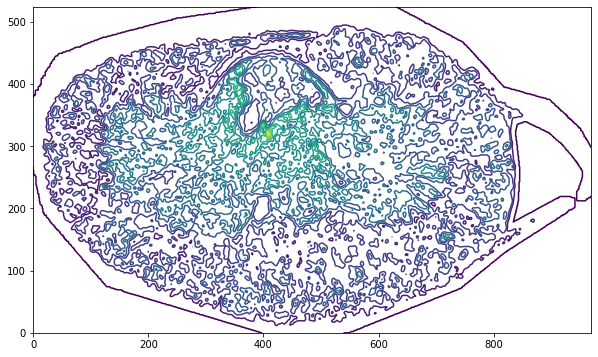

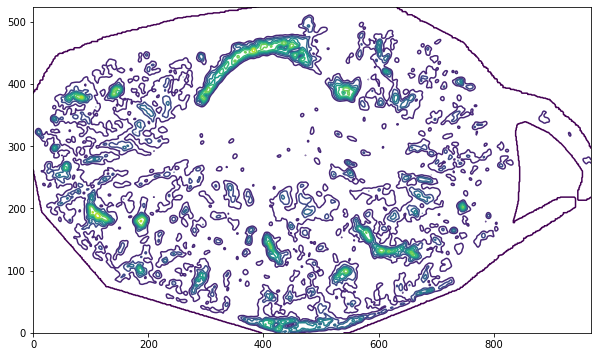

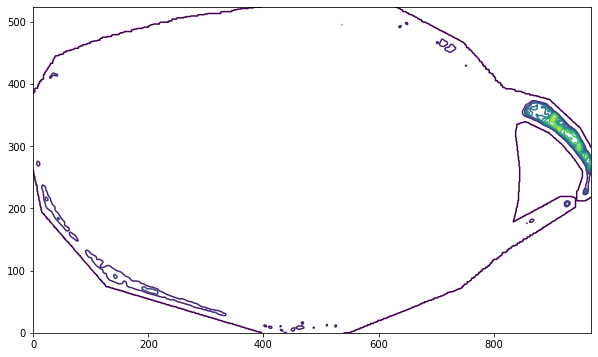

In [58]:
for troi in tissue_rois:
    
    troi_name = troi.replace("/", " ") 
    df = pd.DataFrame(corr_result[troi + '-All'].sort_values(ascending=False)) #sort correlation values from highest to lowest
    df = df[df.index.to_series().apply(lambda x: isinstance(x, float))] #remove non-float rows i.e. those with ROI labels
    top_mz = df.index[0]
    top_mz_idx = np.where(mz_vals==top_mz)[0]
    intensity_vector = ims_intensity_data_norm_df.iloc[:,top_mz_idx]
    intensity_vector = intensity_vector.iloc[:,0]
    top_mz_ion_image = gen_ion_image(intensity_vector, yx_coords)

    #create contour map
    
    # apply Gaussian blur, creating a new image
    image = top_mz_ion_image
    sigma = 2.0
    blurred = skimage.filters.gaussian(
        image, sigma=(sigma, sigma), truncate=3.5)

    # Creating 2-D grid of features
    [X, Y] = np.meshgrid(np.unique(yx_coords[:, 0]), np.unique(yx_coords[:, 1]))
    fig, ax = plt.subplots(1, 1, figsize=(10,6))
    # plots filled contour plot
    contour_data = ax.contour(X, Y, blurred.transpose(), 10)
    
    #save contours as geojson
    all_contours = []
    for idx, collection in enumerate(contour_data.collections):
      #  print(contour_data.levels[idx])
        for cnt in collection.get_paths():
            vertices = cnt.vertices
            if len(vertices) > 1:
                cnt_gj = mpl_contour_to_geojson(vertices, contour_data.levels[idx], [x_translate,y_translate], 10/0.65, name="mz" + str(top_mz))
                all_contours.append(cnt_gj)

    with open("C:/Users/sharmak1/Desktop/210729_AutomatedMaskGeneration/data/Aligned_Annotated_IMS/outs/" + date + "_" + troi_name + ".geojson","w") as f:
        json.dump(all_contours, f)

In [34]:
import json
import numpy as np
import napari
import cv2

#set colormap to start at white
turbo = cm.get_cmap('turbo', 1000)
turbo.colors[0] = [1,1,1,1]



viewer = napari.Viewer()

for troi in tissue_rois:
    
    # set draw thickness
    line_thickness = 10
    
    troi_name = troi.replace("/", " ") 
    gj_data = json.load(open("C:/Users/sharmak1/Desktop/210729_AutomatedMaskGeneration/data/Aligned_Annotated_IMS/outs/" + date + "_" + troi_name + ".geojson", "r"))

    # load in contours, flip order in axis=1
    contours = [np.squeeze(np.asarray(s["geometry"]["coordinates"])) for s in gj_data]
    cnt_vals = [s["properties"]["measurements"][0]["value"] for s in gj_data]
    
    # need a shape for the image, use max in x and y
    max_x = np.max([np.max(c[:,0]) for c in contours])
    max_y = np.max([np.max(c[:,1]) for c in contours])
    
    # for display
    cnt_max = np.max(cnt_vals)
    
    
    # create empty contour image, dtype might need to be uint32 in if there are
    # intensity values > 65565
    # check cnt_max
    contour_image = np.zeros((int(max_y)+10, int(max_x)+10), dtype=np.uint16)
    
    for cnt, cval in zip(contours,cnt_vals):
        contour_image = cv2.polylines(contour_image, [cnt.astype(np.int32)], True, cval, line_thickness)
    
    
    viewer.add_image(contour_image, contrast_limits=[0,cnt_max], name = troi_name, colormap = turbo.colors)
    
    
#UPDATE TIFFFILE
#pas_image = tifffile_to_dask("T:/BIOMIC/mukid3d/registration2d/MuKid_sec092-PAS_to_postAF_registered.ome.tiff")
#viewer.add_image(pas_image)




In [38]:
viewer = napari.Viewer()

for troi in tissue_rois:
    troi_name = troi.replace("/", " ") 
    df = pd.DataFrame(corr_result[troi + '-All'].sort_values(ascending=False)) #sort correlation values from highest to lowest
    df = df[df.index.to_series().apply(lambda x: isinstance(x, float))] #remove non-float rows i.e. those with ROI labels
    top_mz = df.index[0]
    top_mz_idx = np.where(mz_vals==top_mz)[0]
    intensity_vector = ims_intensity_data_norm_df.iloc[:,top_mz_idx]
    intensity_vector = intensity_vector.iloc[:,0]
    top_mz_ion_image = gen_ion_image(intensity_vector, yx_coords)
    viewer.add_image(top_mz_ion_image, name = troi_name, colormap = 'viridis')

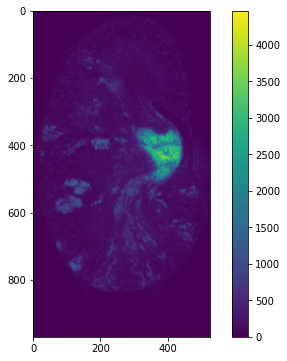

In [72]:
test = ['Bacterial Colony']

for troi in test:
    troi_name = troi.replace("/", " ") 
    df = pd.DataFrame(corr_result[troi + '-All'].sort_values(ascending=False)) #sort correlation values from highest to lowest
    df = df[df.index.to_series().apply(lambda x: isinstance(x, float))] #remove non-float rows i.e. those with ROI labels
    top_mz = df.index[0]
    top_mz_idx = np.where(mz_vals==top_mz)[0]
    intensity_vector = ims_intensity_data_norm_df.iloc[:,top_mz_idx]
    intensity_vector = intensity_vector.iloc[:,0]
    top_mz_ion_image = gen_ion_image(intensity_vector, yx_coords)
    
    
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    plt.imshow(top_mz_ion_image)
    #plt.axis([325,500,275,550])
    plt.colorbar()
    

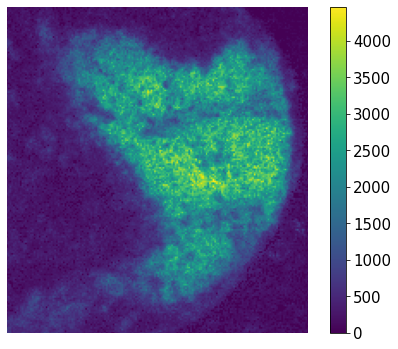

In [78]:
test = ['Bacterial Colony']

for troi in test:
    troi_name = troi.replace("/", " ") 
    df = pd.DataFrame(corr_result[troi + '-All'].sort_values(ascending=False)) #sort correlation values from highest to lowest
    df = df[df.index.to_series().apply(lambda x: isinstance(x, float))] #remove non-float rows i.e. those with ROI labels
    top_mz = df.index[0]
    top_mz_idx = np.where(mz_vals==top_mz)[0]
    intensity_vector = ims_intensity_data_norm_df.iloc[:,top_mz_idx]
    intensity_vector = intensity_vector.iloc[:,0]
    top_mz_ion_image = gen_ion_image(intensity_vector, yx_coords)
    
    
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    plt.imshow(top_mz_ion_image)
    plt.axis([275,450,525,335])
    plt.axis('off')
    plt.colorbar().ax.tick_params(labelsize=15)
    
    plt.savefig("C:/Users/sharmak1/Desktop/210729_AutomatedMaskGeneration/data/Aligned_Annotated_IMS/outs/mz742_zoomed_colorbar.png")

In [ ]:
# Creating 2-D grid of features
[X, Y] = np.meshgrid(np.unique(yx_coords[:, 0]), np.unique(yx_coords[:, 1]))
fig, ax = plt.subplots(1, 1, figsize=(8,6))
# plots filled contour plot
contour_data = ax.contour(X, Y, blurred.transpose(), 10, cmap='viridis')
plt.axis([325,525,275,450])
fig.colorbar(contour_data)
plt.clabel(contour_data, inline=True, fontsize=10)
#plt.savefig("C:/Users/sharmak1/Desktop/210729_AutomatedMaskGeneration/data/Aligned_Annotated_IMS/outs/test.png")

In [88]:
tissue_rois

['Bacterial Colony',
 'Freeze artifact',
 'Inflammatory cell infiltrate',
 'Major Abcess',
 'Renal cortex',
 'Renal medulla',
 'Renal pelvis',
 'Tissue fold/debris overlying tissue']

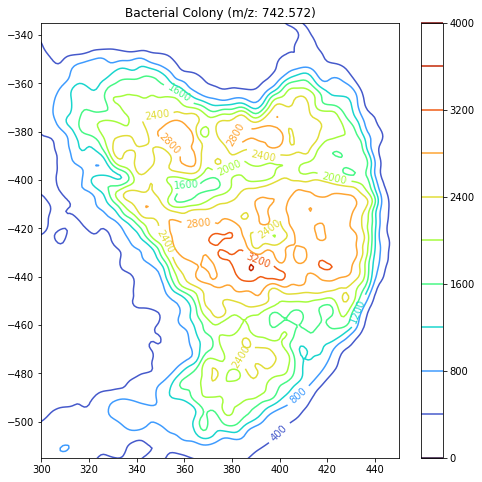

In [40]:
test = ['Bacterial Colony']

for troi in test:
    
    troi_name = troi.replace("/", " ") 
    df = pd.DataFrame(corr_result[troi + '-All'].sort_values(ascending=False)) #sort correlation values from highest to lowest
    df = df[df.index.to_series().apply(lambda x: isinstance(x, float))] #remove non-float rows i.e. those with ROI labels
    top_mz = df.index[0]
    top_mz_idx = np.where(mz_vals==top_mz)[0]
    intensity_vector = ims_intensity_data_norm_df.iloc[:,top_mz_idx]
    intensity_vector = intensity_vector.iloc[:,0]
    top_mz_ion_image = gen_ion_image(intensity_vector, yx_coords)
    top_mz_rounded = round(top_mz, 3)

    #create contour map
    
    # apply Gaussian blur, creating a new image
    image = top_mz_ion_image
    sigma = 2.0
    blurred = skimage.filters.gaussian(
        image, sigma=(sigma, sigma), truncate=3.5)

    # Creating 2-D grid of features
    [X, Y] = np.meshgrid(np.unique(yx_coords[:, 0]), np.unique(yx_coords[:, 1]))
    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    # plots filled contour plot
    contour_data = ax.contour(Y, -X, blurred.transpose(), 10, cmap='turbo')
    
    plt.axis([300,450,-515,-335])
    fig.colorbar(contour_data)
    plt.clabel(contour_data, inline=True, fontsize=10)
    plt.title(troi_name + ' (m/z: ' + str(top_mz_rounded) + ')')
    
  #  plt.savefig("C:/Users/sharmak1/Desktop/210729_AutomatedMaskGeneration/data/Aligned_Annotated_IMS/outs/" + date + "_" + troi_name + "_zoomed_clabeled.svg")

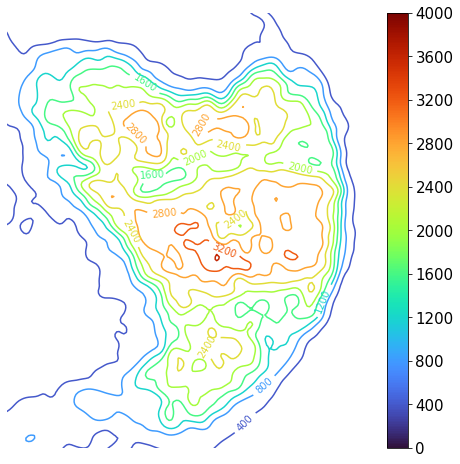

In [65]:
test = ['Bacterial Colony']

for troi in test:
    
    troi_name = troi.replace("/", " ") 
    df = pd.DataFrame(corr_result[troi + '-All'].sort_values(ascending=False)) #sort correlation values from highest to lowest
    df = df[df.index.to_series().apply(lambda x: isinstance(x, float))] #remove non-float rows i.e. those with ROI labels
    top_mz = df.index[0]
    top_mz_idx = np.where(mz_vals==top_mz)[0]
    intensity_vector = ims_intensity_data_norm_df.iloc[:,top_mz_idx]
    intensity_vector = intensity_vector.iloc[:,0]
    top_mz_ion_image = gen_ion_image(intensity_vector, yx_coords)
    top_mz_rounded = round(top_mz, 3)

    #create contour map
    
    # apply Gaussian blur, creating a new image
    image = top_mz_ion_image
    sigma = 2.0
    blurred = skimage.filters.gaussian(
        image, sigma=(sigma, sigma), truncate=3.5)

    # Creating 2-D grid of features
    [X, Y] = np.meshgrid(np.unique(yx_coords[:, 0]), np.unique(yx_coords[:, 1]))
    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    # plots filled contour plot
    contour_data = ax.contour(Y, -X, blurred.transpose(), 10, cmap='turbo')
    
    #make colorbar continuous
    norm = matplotlib.colors.Normalize(vmin=contour_data.cvalues.min(), vmax=contour_data.cvalues.max())
    sm = plt.cm.ScalarMappable(norm=norm, cmap = contour_data.cmap)
    sm.set_array([])
    fig.colorbar(sm, ticks=contour_data.levels).ax.tick_params(labelsize=15)
    
    plt.axis([300,450,-515,-335])
    plt.axis('off')
   # fig.colorbar(contour_data)
    plt.clabel(contour_data, inline=True, fontsize=10)
    
   # plt.title(troi_name + ' (m/z: ' + str(top_mz_rounded) + ')')
    
    plt.savefig("C:/Users/sharmak1/Desktop/210729_AutomatedMaskGeneration/data/Aligned_Annotated_IMS/outs/" + date + "_" + troi_name + "_zoomed_clabeled_v2.png")

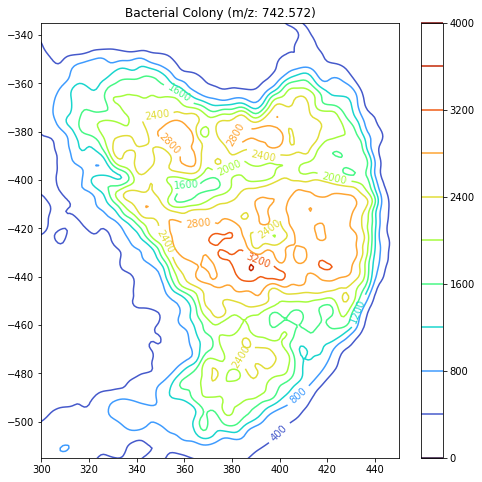

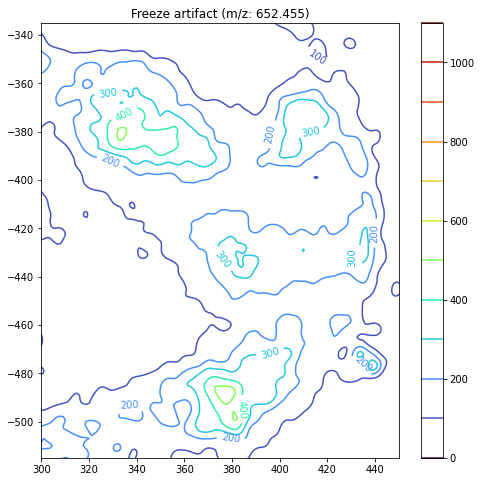

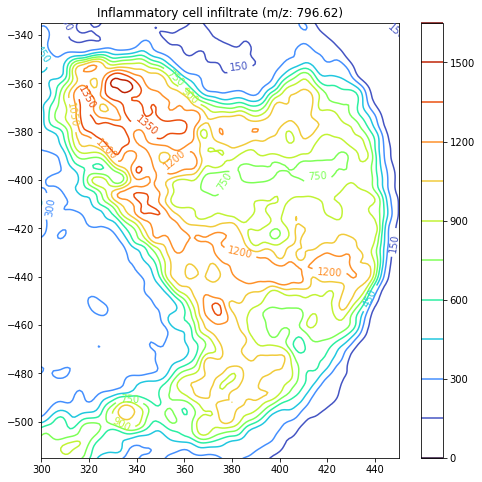

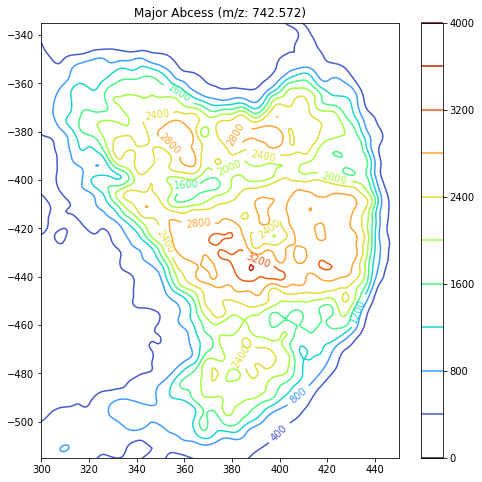

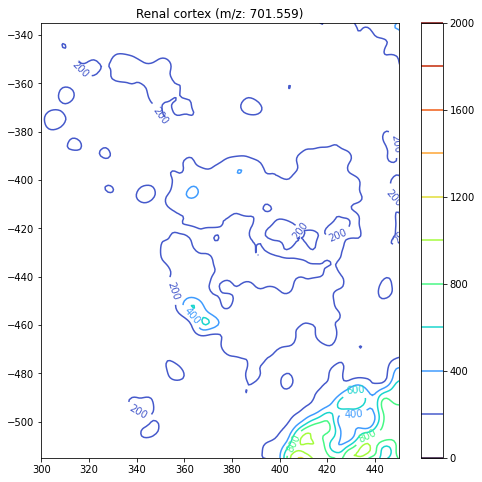

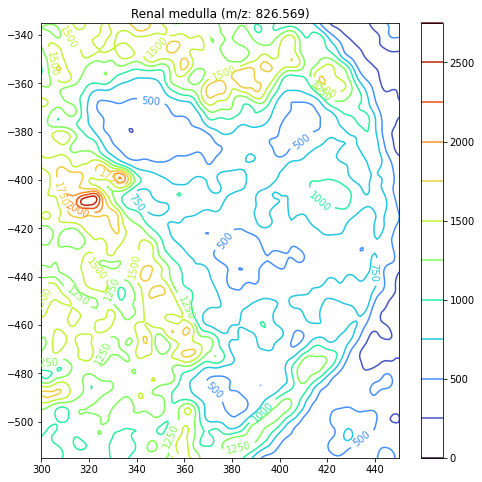

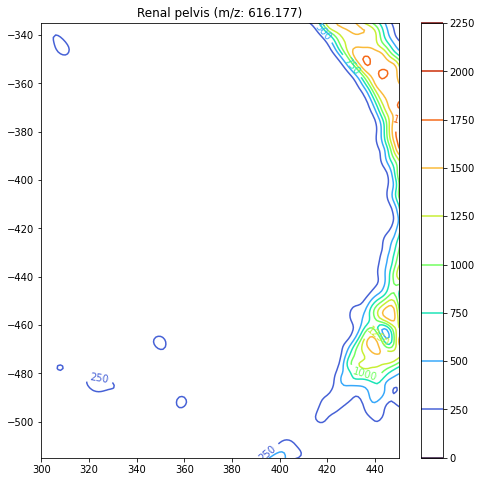

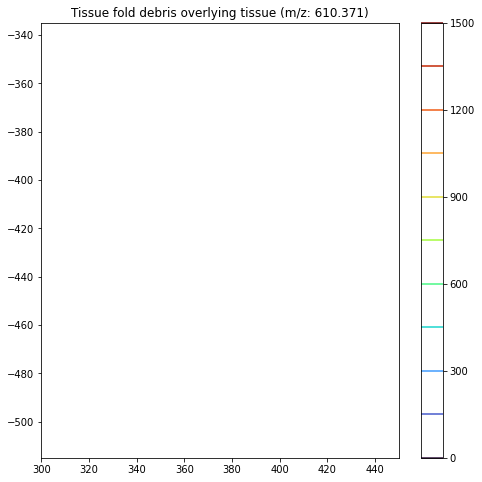

In [171]:
for troi in tissue_rois:
    
    troi_name = troi.replace("/", " ") 
    df = pd.DataFrame(corr_result[troi + '-All'].sort_values(ascending=False)) #sort correlation values from highest to lowest
    df = df[df.index.to_series().apply(lambda x: isinstance(x, float))] #remove non-float rows i.e. those with ROI labels
    top_mz = df.index[0]
    top_mz_idx = np.where(mz_vals==top_mz)[0]
    intensity_vector = ims_intensity_data_norm_df.iloc[:,top_mz_idx]
    intensity_vector = intensity_vector.iloc[:,0]
    top_mz_ion_image = gen_ion_image(intensity_vector, yx_coords)
    top_mz_rounded = round(top_mz, 3)

    #create contour map
    
    # apply Gaussian blur, creating a new image
    image = top_mz_ion_image
    sigma = 2.0
    blurred = skimage.filters.gaussian(
        image, sigma=(sigma, sigma), truncate=3.5)

    # Creating 2-D grid of features
    [X, Y] = np.meshgrid(np.unique(yx_coords[:, 0]), np.unique(yx_coords[:, 1]))
    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    # plots filled contour plot
    contour_data = ax.contour(Y, -X, blurred.transpose(), 10, cmap='turbo')
    
    plt.axis([300,450,-515,-335])
    fig.colorbar(contour_data)
    plt.clabel(contour_data, inline=True, fontsize=10)
    plt.title(troi_name + ' (m/z: ' + str(top_mz_rounded) + ')')
    
    plt.savefig("C:/Users/sharmak1/Desktop/210729_AutomatedMaskGeneration/data/Aligned_Annotated_IMS/outs/" + date + "_" + troi_name + "_zoomed_clabeled.svg")

### Examples with no gaussian blur, sigma = 2.0, and sigma = 4.0

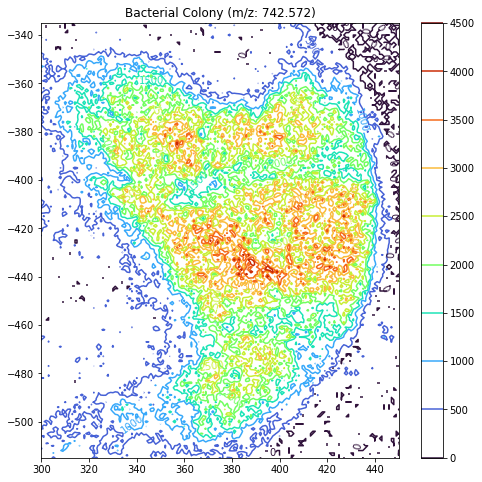

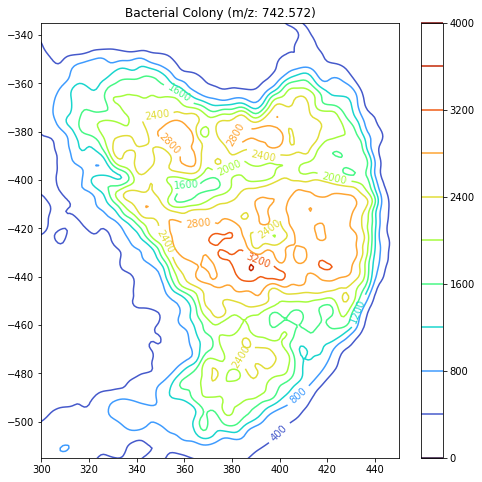

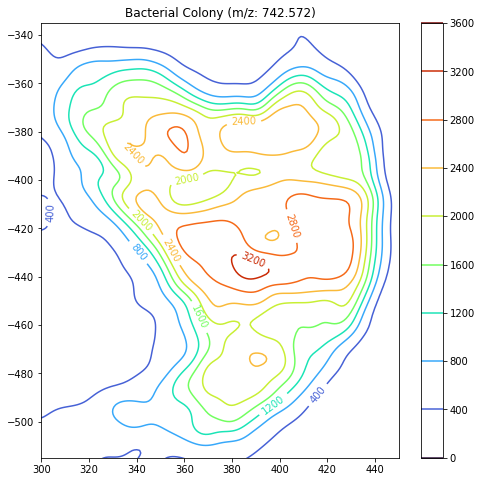

In [174]:
sigmas = [0, 2.0, 4.0]

troi = 'Bacterial Colony'
    
troi_name = troi.replace("/", " ") 
df = pd.DataFrame(corr_result[troi + '-All'].sort_values(ascending=False)) #sort correlation values from highest to lowest
df = df[df.index.to_series().apply(lambda x: isinstance(x, float))] #remove non-float rows i.e. those with ROI labels
top_mz = df.index[0]
top_mz_idx = np.where(mz_vals==top_mz)[0]
intensity_vector = ims_intensity_data_norm_df.iloc[:,top_mz_idx]
intensity_vector = intensity_vector.iloc[:,0]
top_mz_ion_image = gen_ion_image(intensity_vector, yx_coords)
top_mz_rounded = round(top_mz, 3)

#create contour map
    
for s in sigmas:
    
    # apply Gaussian blur, creating a new image
    image = top_mz_ion_image
    sigma = s
    blurred = skimage.filters.gaussian(
        image, sigma=(sigma, sigma), truncate=3.5)

    # Creating 2-D grid of features
    [X, Y] = np.meshgrid(np.unique(yx_coords[:, 0]), np.unique(yx_coords[:, 1]))
    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    # plots filled contour plot
    contour_data = ax.contour(Y, -X, blurred.transpose(), 10, cmap='turbo')
    
    plt.axis([300,450,-515,-335])
    fig.colorbar(contour_data)
    plt.clabel(contour_data, inline=True, fontsize=10)
    plt.title(troi_name + ' (m/z: ' + str(top_mz_rounded) + ')')
    
    plt.savefig("C:/Users/sharmak1/Desktop/210729_AutomatedMaskGeneration/data/Aligned_Annotated_IMS/outs/" + date + "_" + troi_name + "_sigma_" + str(s) + ".svg")

## NMF 

### Testing NMF n_components

In [28]:
ims_intensity_data_norm_df.columns = ims_intensity_data_norm_df.columns.astype('str')

In [221]:
reconstruction_err = pd.DataFrame(columns = ['n_components', 'reconstructionError'])

for k in range(1,101):
    model = NMF(n_components=k, init='random', random_state=0)
    W = model.fit_transform(ims_intensity_data_norm_df)
    H = model.components_
    reconstruction_err = pd.concat([reconstruction_err, 
                                    pd.DataFrame.from_records([{'n_components': k, 
                                                                'reconstructionError': model.reconstruction_err_}])])
    print("NMF with " + str(k) + ' components complete.')
    


NMF with 1 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 2 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 3 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 4 components complete.
NMF with 5 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 6 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 7 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 8 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 9 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 10 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 11 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 12 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 13 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 14 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 15 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 16 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 17 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 18 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 19 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 20 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 21 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 22 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 23 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 24 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 25 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 26 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 27 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 28 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 29 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 30 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 31 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 32 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 33 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 34 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 35 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 36 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 37 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 38 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 39 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 40 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 41 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 42 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 43 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 44 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 45 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 46 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 47 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 48 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 49 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 50 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 51 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 52 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 53 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 54 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 55 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 56 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 57 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 58 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 59 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 60 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 61 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 62 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 63 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 64 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 65 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 66 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 67 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 68 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 69 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 70 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 71 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 72 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 73 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 74 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 75 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 76 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 77 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 78 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 79 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 80 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 81 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 82 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 83 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 84 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 85 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 86 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 87 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 88 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 89 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 90 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 91 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 92 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 93 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 94 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 95 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 96 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 97 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 98 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 99 components complete.


C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF with 100 components complete.


In [222]:
reconstruction_err

n_components reconstructionError
0             1      4749976.295068
0             2      4046881.943177
0             3      3517992.797318
0             4       2990664.00872
0             5        2523740.9145
..          ...                 ...
0            96      1034601.188416
0            97      1029323.060564
0            98      1025226.433557
0            99      1021457.708117
0           100      1018220.811887

[100 rows x 2 columns]

In [224]:
reconstruction_err_df = reconstruction_err.copy()
reconstruction_err_df = reconstruction_err_df.astype('float')
reconstruction_err_df

n_components  reconstructionError
0            1.0         4.749976e+06
0            2.0         4.046882e+06
0            3.0         3.517993e+06
0            4.0         2.990664e+06
0            5.0         2.523741e+06
..           ...                  ...
0           96.0         1.034601e+06
0           97.0         1.029323e+06
0           98.0         1.025226e+06
0           99.0         1.021458e+06
0          100.0         1.018221e+06

[100 rows x 2 columns]

In [225]:
reconstruction_err_df.dtypes

n_components           float64
reconstructionError    float64
dtype: object

In [226]:
reconstruction_err_df.to_csv('C:/Users/sharmak1/Desktop/210729_AutomatedMaskGeneration/data/Aligned_Annotated_IMS/outs/' + date + '_NMF_reconstructionError.csv')

<AxesSubplot:xlabel='n_components'>

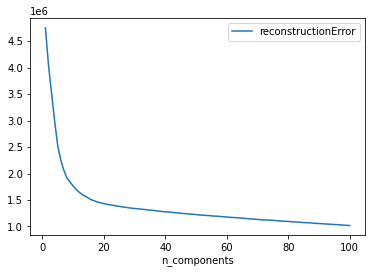

In [180]:
reconstruction_err_df.set_index('n_components').plot()

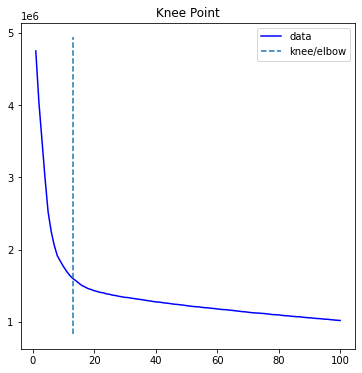

In [181]:
from kneed import KneeLocator

kneedle = KneeLocator(
    x=reconstruction_err_df['n_components'], 
    y=reconstruction_err_df['reconstructionError'], 
    S=1.0, 
    curve="convex", 
    direction="decreasing")

kneedle.plot_knee()
plt.savefig('C:/Users/sharmak1/Desktop/210729_AutomatedMaskGeneration/data/Aligned_Annotated_IMS/outs/' + date + '_NMF_kneedlePlot.svg')

In [182]:
print(kneedle.knee)

13.0


In [29]:
#change column dtype to str for NMF (else, throws a warning)
ims_intensity_data_norm_df_forNMF = ims_intensity_data_norm_df.copy()
ims_intensity_data_norm_df_forNMF.columns = ims_intensity_data_norm_df_forNMF.columns.astype('str')

In [30]:
#k = int(kneedle.knee)
k=13
model = NMF(n_components=k, init='random', random_state=0)
W  = model.fit_transform(ims_intensity_data_norm_df_forNMF)
H = model.components_

C:\ProgramData\Anaconda3\envs\napariEnv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [31]:
viewer = napari.Viewer()

for i in range(1, k+1):
    df_W = W[:,i-1]
    df_NMF = gen_ion_image(df_W, yx_coords)
    viewer.add_image(df_NMF, name='NMF' + str(i), colormap='viridis')

In [340]:
for i in range(0, k):
    
    nmf_name = 'NMF' + str(i+1) 
    
    #generate ion image for nmf
    W1 = W[:,i]
    nmf = gen_ion_image(W1, yx_coords)
    
    imwrite("C:/Users/sharmak1/Desktop/210729_AutomatedMaskGeneration/data/Aligned_Annotated_IMS/outs/" + date + "_" + nmf_name + ".tiff", nmf, compression="deflate")


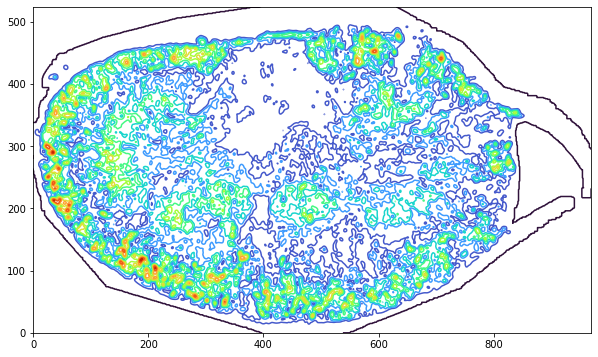

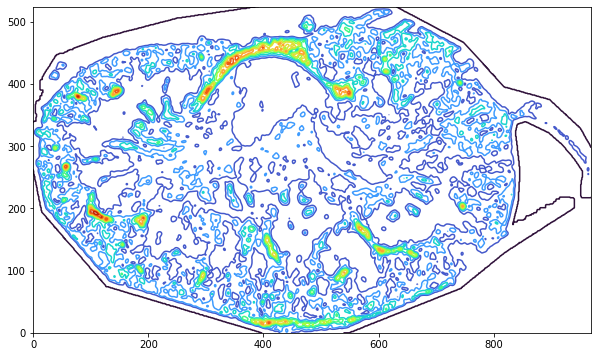

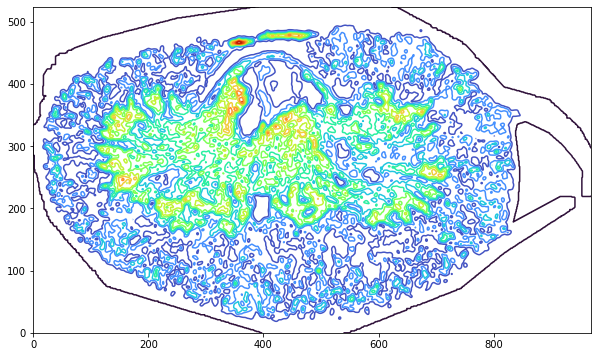

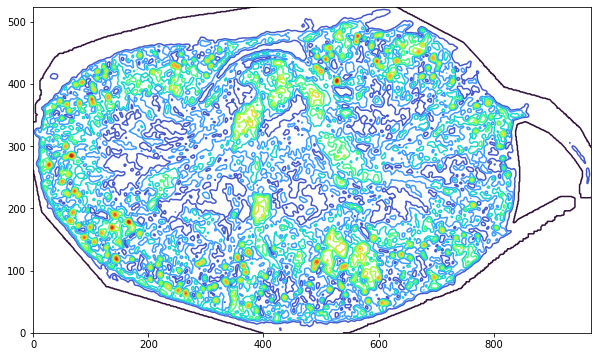

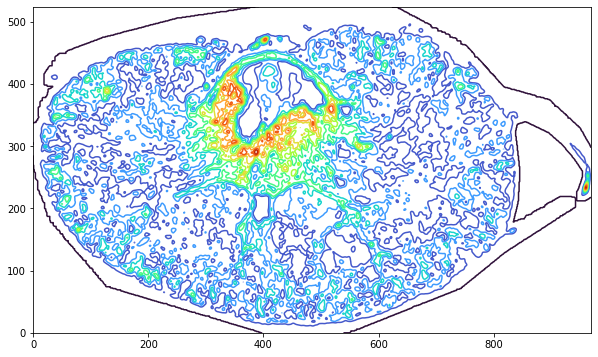

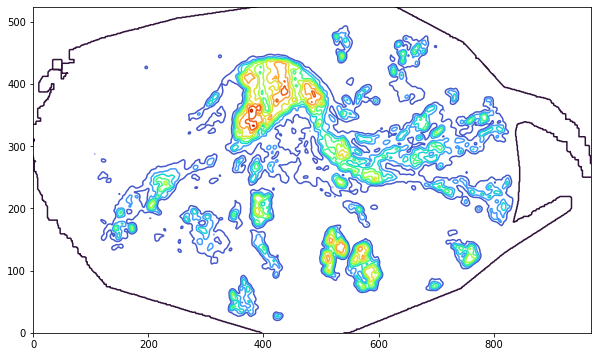

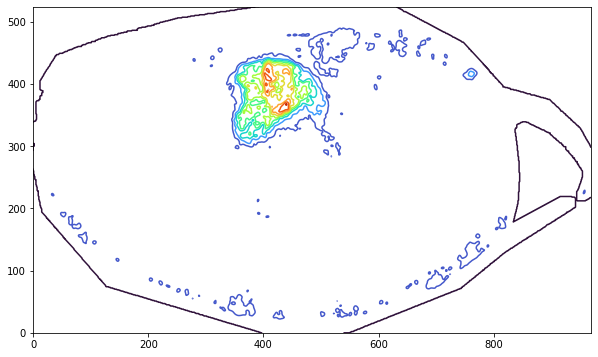

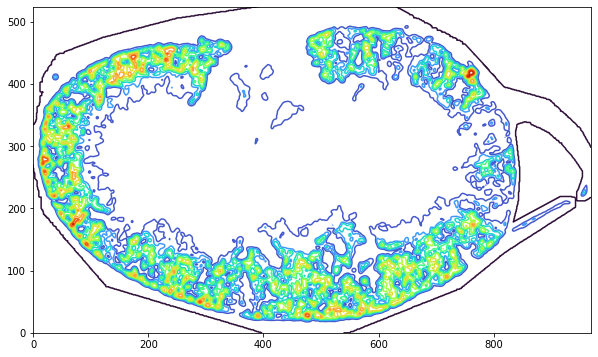

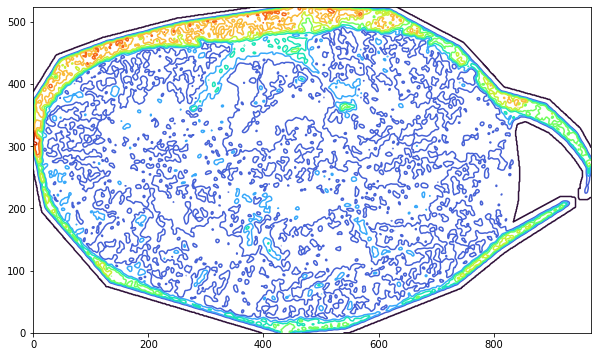

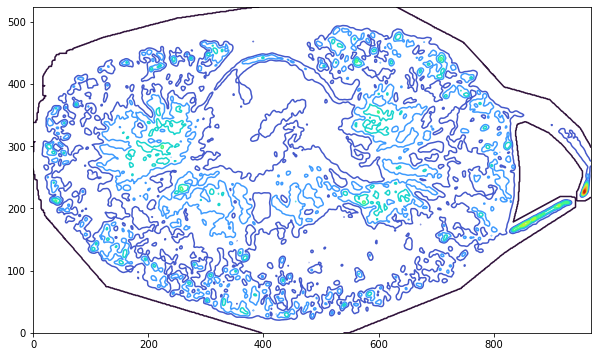

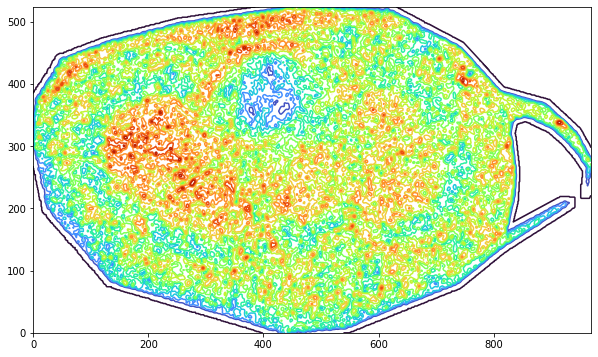

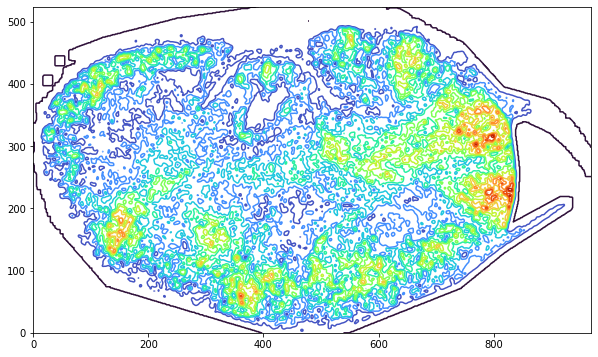

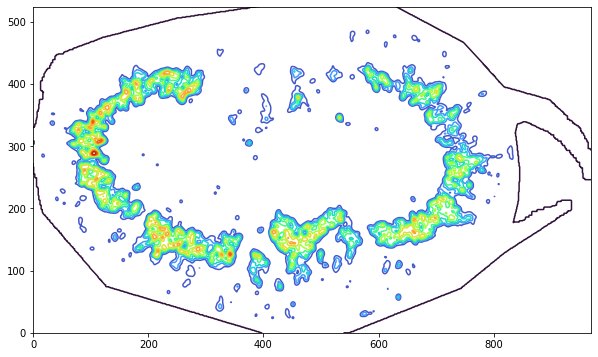

In [32]:
#create contour maps for each NMF component and save as geoJSON

for i in range(0, k):
    
    nmf_name = 'NMF' + str(i+1) 
    
    #generate ion image for nmf
    W1 = W[:,i]
    nmf = gen_ion_image(W1, yx_coords)
    

    #create contour map
    
    # apply Gaussian blur, creating a new image
    image = nmf
    sigma = 2.0
    blurred = skimage.filters.gaussian(
        image, sigma=(sigma, sigma), truncate=3.5)

    # Creating 2-D grid of features
    [X, Y] = np.meshgrid(np.unique(yx_coords[:, 0]), np.unique(yx_coords[:, 1]))
    fig, ax = plt.subplots(1, 1, figsize=(10,6))
    # plots filled contour plot
    contour_data = ax.contour(X, Y, blurred.transpose(), 10, cmap='turbo')
    
    #save contours as geojson
    all_contours = []
    for idx, collection in enumerate(contour_data.collections):
      #  print(contour_data.levels[idx])
        for cnt in collection.get_paths():
            vertices = cnt.vertices
            if len(vertices) > 1:
                cnt_gj = mpl_contour_to_geojson(vertices, contour_data.levels[idx], [x_translate,y_translate], 10/0.65, name=nmf_name)
                all_contours.append(cnt_gj)

    with open("C:/Users/sharmak1/Desktop/210729_AutomatedMaskGeneration/data/Aligned_Annotated_IMS/outs/" + date + "_" + nmf_name + ".geojson","w") as f:
        json.dump(all_contours, f)

In [33]:
import json
import numpy as np
import napari
import cv2

#set colormap to start at white
turbo = cm.get_cmap('turbo', 1000)
turbo.colors[0] = [1,1,1,1]

viewer = napari.Viewer()

for i in range(0, k):
    
    nmf_name = 'NMF' + str(i+1) 
    
    # set draw thickness
    line_thickness = 10
    
    gj_data = json.load(open("C:/Users/sharmak1/Desktop/210729_AutomatedMaskGeneration/data/Aligned_Annotated_IMS/outs/" + date + "_" + nmf_name + ".geojson", "r"))

    # load in contours, flip order in axis=1
    contours = [np.squeeze(np.asarray(s["geometry"]["coordinates"])) for s in gj_data]
    cnt_vals = [s["properties"]["measurements"][0]["value"] for s in gj_data]
    
    # need a shape for the image, use max in x and y
    max_x = np.max([np.max(c[:,0]) for c in contours])
    max_y = np.max([np.max(c[:,1]) for c in contours])
    
    # for display
    cnt_max = np.max(cnt_vals)
    
    
    # create empty contour image, dtype might need to be uint32 in if there are
    # intensity values > 65565
    # check cnt_max
    contour_image = np.zeros((int(max_y)+10, int(max_x)+10), dtype=np.uint16)
    
    for cnt, cval in zip(contours,cnt_vals):
        contour_image = cv2.polylines(contour_image, [cnt.astype(np.int32)], True, cval, line_thickness)
    
    
    viewer.add_image(contour_image, contrast_limits=[0,cnt_max], name = nmf_name, colormap = turbo.colors)
    
    
    
#pas_image = tifffile_to_dask("T:/BIOMIC/mukid3d/registration2d/MuKid_sec092-PAS_to_postAF_registered.ome.tiff")
#viewer.add_image(pas_image)




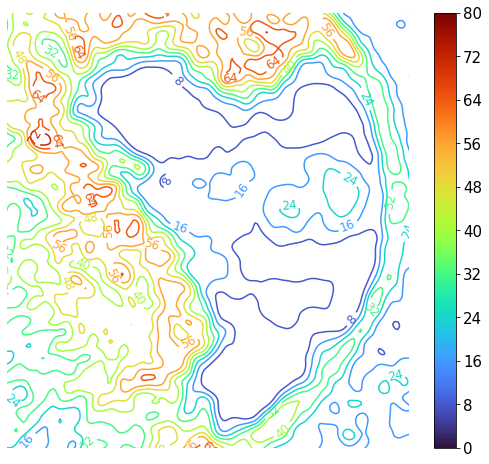

In [63]:
#make individual zoomed in and full scale maps for NMFs of interest (NMF 5)

#generate ion image for nmf
W1 = W[:,4]
nmf = gen_ion_image(W1, yx_coords)

#create contour map
    
# apply Gaussian blur, creating a new image
image = nmf
sigma = 2.0
blurred = skimage.filters.gaussian(
    image, sigma=(sigma, sigma), truncate=3.5)

# Creating 2-D grid of features
[X, Y] = np.meshgrid(np.unique(yx_coords[:, 0]), np.unique(yx_coords[:, 1]))
fig, ax = plt.subplots(1, 1, figsize=(9,8))
# plots filled contour plot
contour_data = ax.contour(Y, -X, blurred.transpose(), 10, cmap="turbo")
plt.axis([275,450,-515,-335])
plt.axis('off')
plt.clabel(contour_data, inline=True, fontsize=12)

#make colorbar continuous
norm = matplotlib.colors.Normalize(vmin=contour_data.cvalues.min(), vmax=contour_data.cvalues.max())
sm = plt.cm.ScalarMappable(norm=norm, cmap = contour_data.cmap)
sm.set_array([])
fig.colorbar(sm, ticks=contour_data.levels).ax.tick_params(labelsize=15)

plt.savefig("C:/Users/sharmak1/Desktop/210729_AutomatedMaskGeneration/data/Aligned_Annotated_IMS/outs/" + date + "_NMF5_WSI_zoomed_v2.pdf")



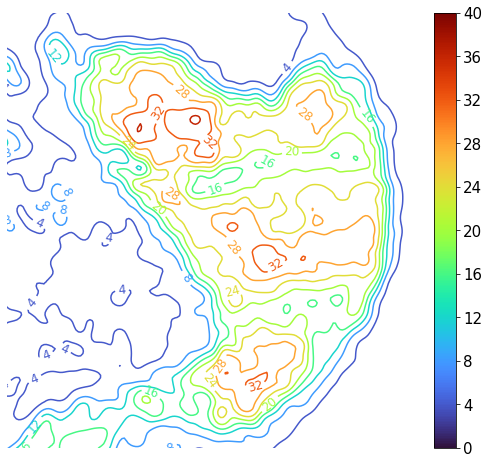

In [62]:
#make individual zoomed in and full scale maps for NMFs of interest (NMF 6)

#generate ion image for nmf
W1 = W[:,5]
nmf = gen_ion_image(W1, yx_coords)

#create contour map
    
# apply Gaussian blur, creating a new image
image = nmf
sigma = 2.0
blurred = skimage.filters.gaussian(
    image, sigma=(sigma, sigma), truncate=3.5)

# Creating 2-D grid of features
[X, Y] = np.meshgrid(np.unique(yx_coords[:, 0]), np.unique(yx_coords[:, 1]))
fig, ax = plt.subplots(1, 1, figsize=(9,8))

# plots filled contour plot
contour_data = ax.contour(Y, -X, blurred.transpose(), 10, cmap="turbo")
plt.axis([275,450,-515,-335])
plt.axis('off')
plt.clabel(contour_data, inline=True, fontsize=12)

#make colorbar continuous
norm = matplotlib.colors.Normalize(vmin=contour_data.cvalues.min(), vmax=contour_data.cvalues.max())
sm = plt.cm.ScalarMappable(norm=norm, cmap = contour_data.cmap)
sm.set_array([])
fig.colorbar(sm, ticks=contour_data.levels).ax.tick_params(labelsize=15)

plt.savefig("C:/Users/sharmak1/Desktop/210729_AutomatedMaskGeneration/data/Aligned_Annotated_IMS/outs/" + date + "_NMF6_zoomed_v2.pdf")

### Plot avg spectra per NMF component

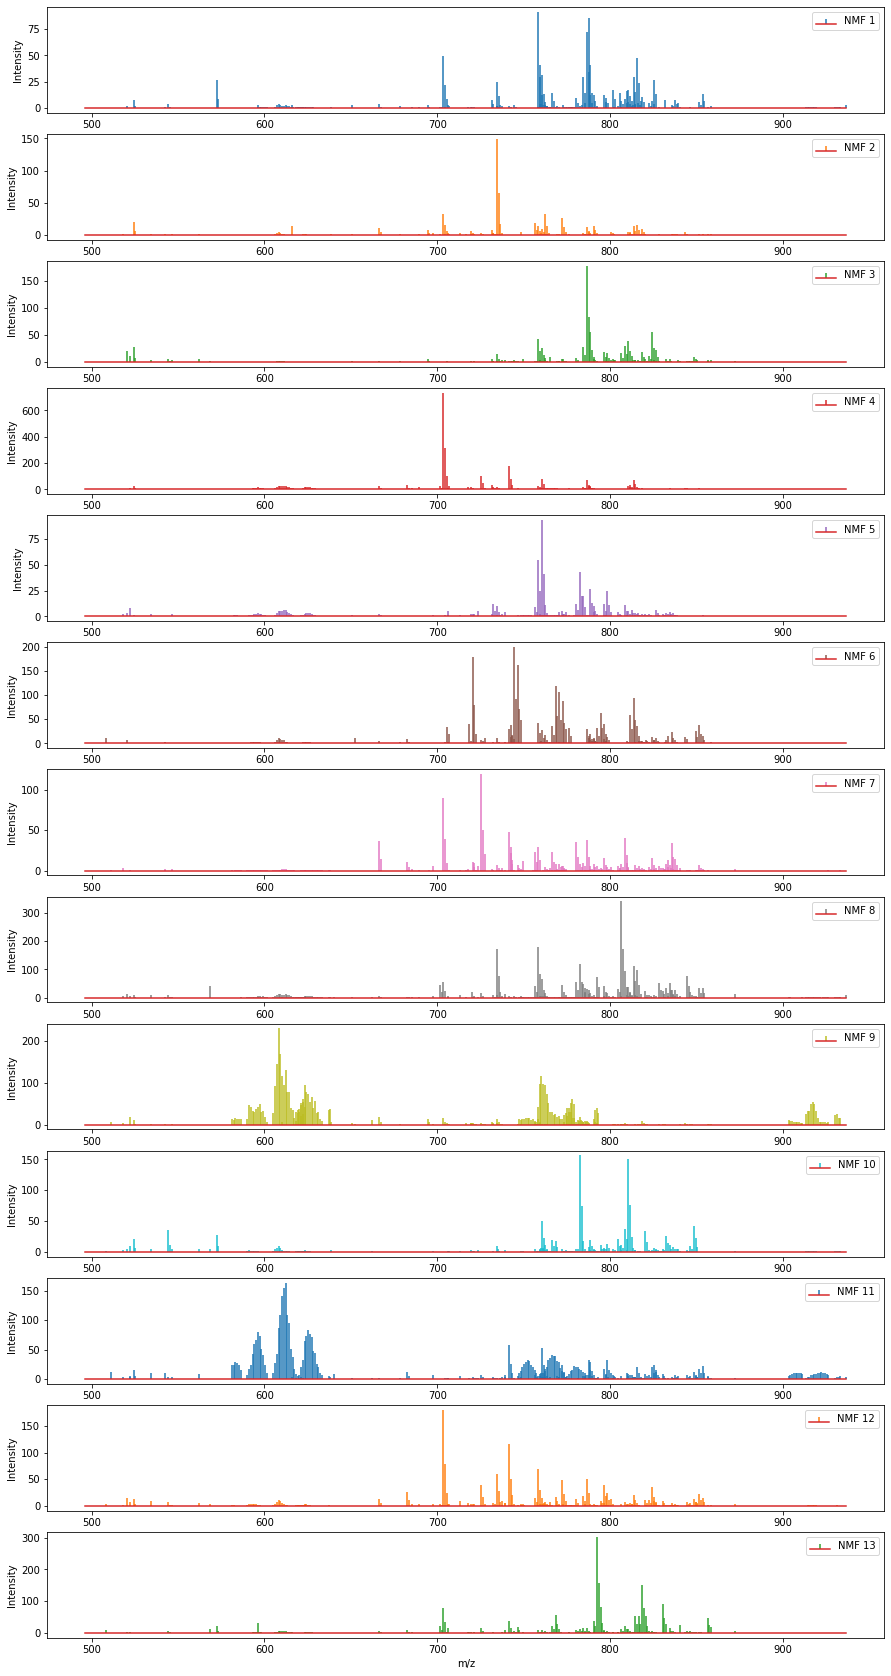

In [314]:
nr_plots = 13

fig, axs = plt.subplots(nr_plots, 1, figsize=(15,30))

for i in range(nr_plots):
    df_H = H[i,:]
    axs[i].stem(mz_vals, df_H, linefmt='C'+str(i), markerfmt=' ', label='NMF '+str(i+1))
    axs[i].grid()
    axs[i].set_ylabel('Intensity')
    axs[i].legend()
    axs[i].grid(False)
 #   axs[i].set_xticks(ticks=[])
plt.xlabel('m/z')
plt.savefig("C:/Users/sharmak1/Desktop/210729_AutomatedMaskGeneration/data/Aligned_Annotated_IMS/outs/" + date + "_NMF_allPlots.png")